In [1]:
# 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded")

Libraries loaded


In [2]:
# 2: Load data and create binary target
df = pd.read_csv('../data/raw/insurance_claims_raw.csv')

# Create binary fraud column (0=No, 1=Yes)
df['FraudFound_P'] = (df['FraudFound'] == 'Yes').astype(int)

print(f"Shape: {df.shape}")
print(f"Fraud cases: {df['FraudFound_P'].sum()}")
print(f"Fraud rate: {df['FraudFound_P'].mean()*100:.2f}%")
print(f"\nOriginal values: {df['FraudFound'].unique()}")
print(f"Binary values: {df['FraudFound_P'].unique()}")

Shape: (15420, 34)
Fraud cases: 923
Fraud rate: 5.99%

Original values: ['No' 'Yes']
Binary values: [0 1]


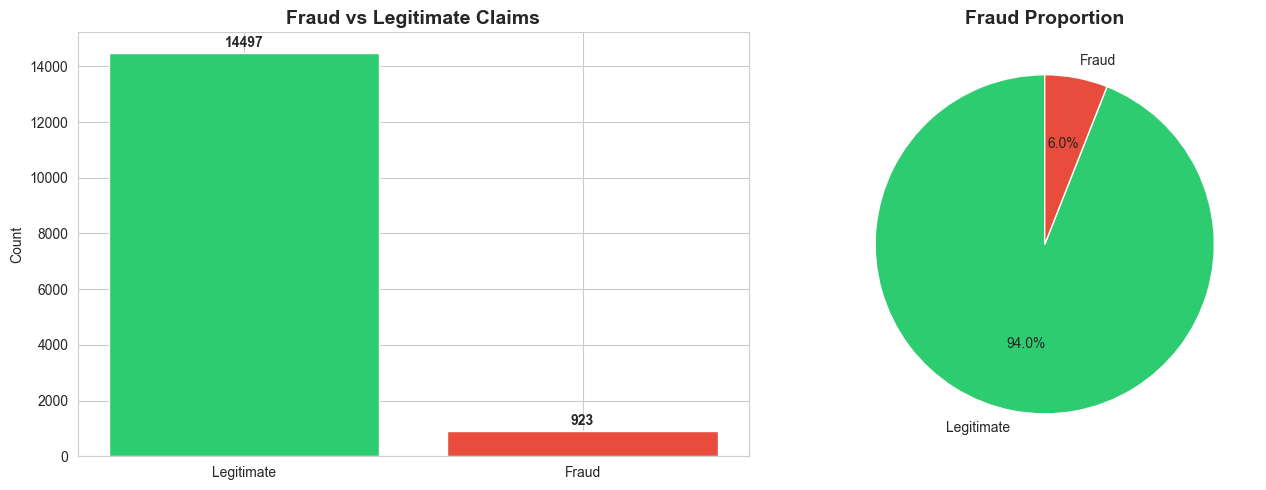

Class Imbalance Ratio: 1:15


In [3]:
# 3: Fraud distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
fraud_counts = df['FraudFound_P'].value_counts()
axes[0].bar(['Legitimate', 'Fraud'], fraud_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Fraud vs Legitimate Claims', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 200, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(fraud_counts.values, labels=['Legitimate', 'Fraud'], 
            autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'],
            startangle=90)
axes[1].set_title('Fraud Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/fraud_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Class Imbalance Ratio: 1:{int(fraud_counts[0]/fraud_counts[1])}")

In [4]:
# 4: Identify numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove ID columns
numerical_cols = [col for col in numerical_cols if col not in ['PolicyNumber', 'FraudFound_P']]
print(f"Numerical features: {numerical_cols}")

Numerical features: ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'RepNumber', 'Deductible', 'DriverRating', 'Year']


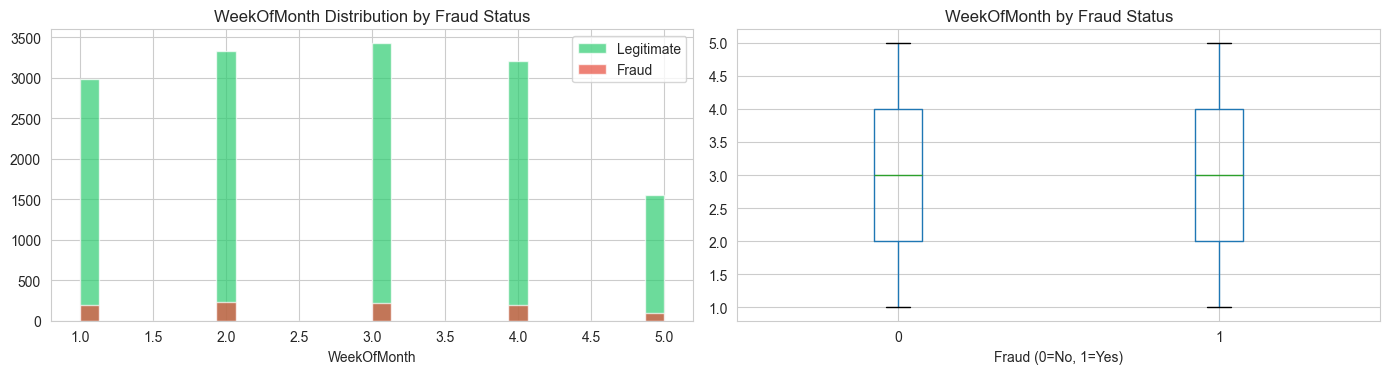

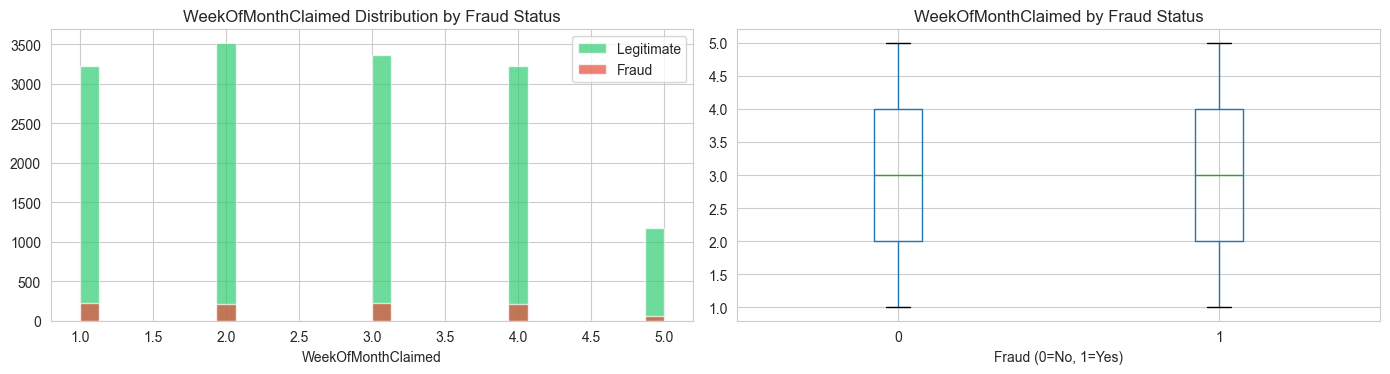

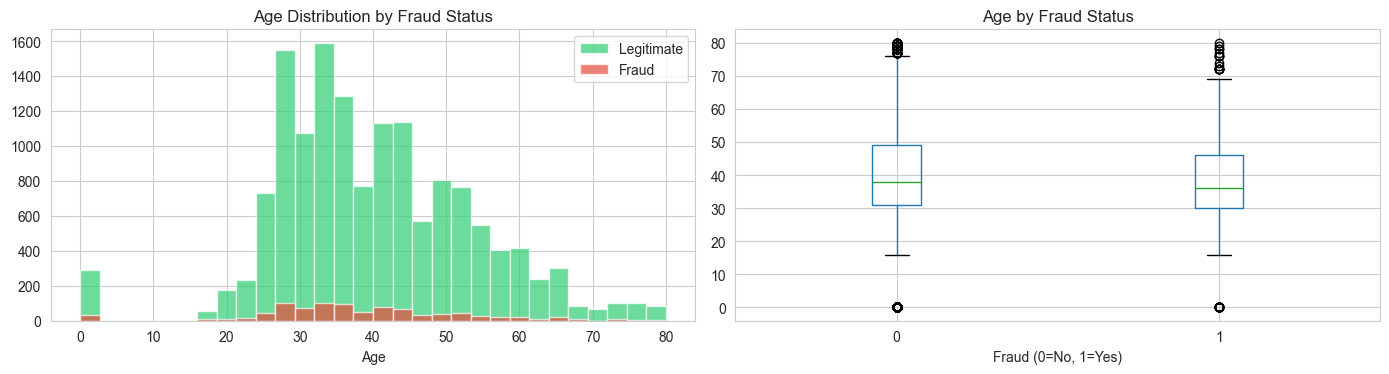

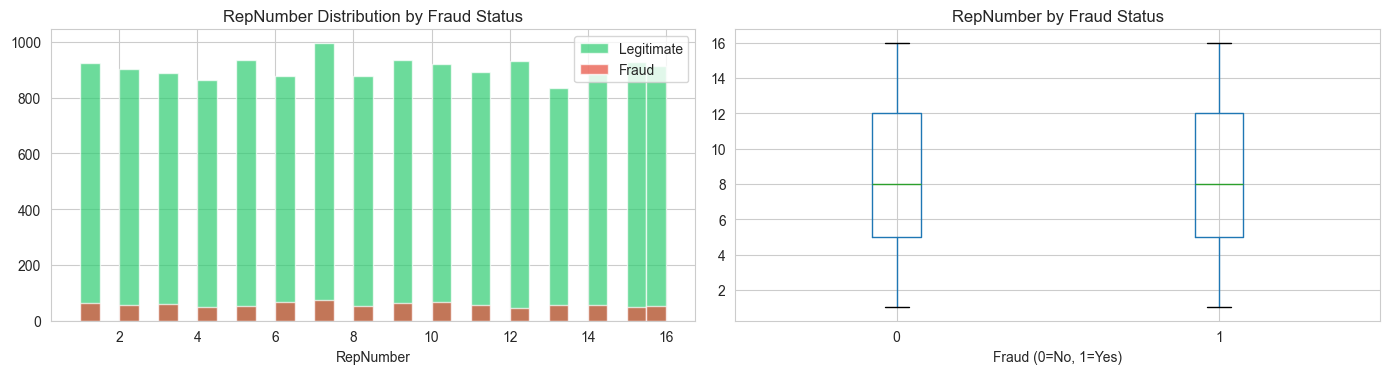

In [5]:
# 5: Distribution of numerical features by fraud status
for col in numerical_cols[:4]:  # First 4 numerical columns
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Histogram by fraud status
    df[df['FraudFound_P']==0][col].hist(bins=30, alpha=0.7, label='Legitimate', 
                                         color='#2ecc71', ax=axes[0])
    df[df['FraudFound_P']==1][col].hist(bins=30, alpha=0.7, label='Fraud', 
                                         color='#e74c3c', ax=axes[0])
    axes[0].set_title(f'{col} Distribution by Fraud Status')
    axes[0].set_xlabel(col)
    axes[0].legend()
    
    # Box plot
    df.boxplot(column=col, by='FraudFound_P', ax=axes[1])
    axes[1].set_title(f'{col} by Fraud Status')
    axes[1].set_xlabel('Fraud (0=No, 1=Yes)')
    plt.suptitle('') #removes the automatic title tht pandas adds above the whole fig. wen u use .boxplot(..., by='...')
    
    plt.tight_layout()
    plt.show()

In [6]:
# 6: Statistical summary by fraud status
print("=== NUMERICAL FEATURES BY FRAUD STATUS ===\n")
for col in numerical_cols:
    print(f"\n{col}:")
    print(df.groupby('FraudFound_P')[col].describe()[['mean', 'std', 'min', 'max']])
    print("-" * 60) # - separator to make it more readable

=== NUMERICAL FEATURES BY FRAUD STATUS ===


WeekOfMonth:
                  mean       std  min  max
FraudFound_P                              
0             2.792440  1.287957  1.0  5.0
1             2.728061  1.280906  1.0  5.0
------------------------------------------------------------

WeekOfMonthClaimed:
                  mean       std  min  max
FraudFound_P                              
0             2.695799  1.259360  1.0  5.0
1             2.665222  1.255596  1.0  5.0
------------------------------------------------------------

Age:
                   mean        std  min   max
FraudFound_P                                 
0             39.956957  13.462013  0.0  80.0
1             38.265439  13.871426  0.0  80.0
------------------------------------------------------------

RepNumber:
                  mean       std  min   max
FraudFound_P                               
0             8.492033  4.604212  1.0  16.0
1             8.345612  4.532690  1.0  16.0
----------------

In [7]:
# 7: Key categorical features - selecting the most promising 
key_categoricals = [
    'PoliceReportFiled', 'WitnessPresent', 'Fault', 'AgentType',
    'AccidentArea', 'Sex', 'MaritalStatus', 'VehicleCategory',
    'PolicyType', 'BasePolicy'
]

In [8]:
# 8: Fraud rate by categorical features
print("=== FRAUD RATE BY CATEGORICAL FEATURES ===\n")

fraud_rates = {}
for col in key_categoricals:
    fraud_rate = df.groupby(col)['FraudFound_P'].agg(['sum', 'count', 'mean'])
    fraud_rate.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
    fraud_rate['Fraud_Rate'] = fraud_rate['Fraud_Rate'] * 100
    fraud_rate = fraud_rate.sort_values('Fraud_Rate', ascending=False)
    
    print(f"\n{col}:")
    print(fraud_rate)
    print("-" * 60)
    
    fraud_rates[col] = fraud_rate

=== FRAUD RATE BY CATEGORICAL FEATURES ===


PoliceReportFiled:
                   Fraud_Count  Total_Count  Fraud_Rate
PoliceReportFiled                                      
No                         907        14992    6.049893
Yes                         16          428    3.738318
------------------------------------------------------------

WitnessPresent:
                Fraud_Count  Total_Count  Fraud_Rate
WitnessPresent                                      
No                      920        15333    6.000130
Yes                       3           87    3.448276
------------------------------------------------------------

Fault:
               Fraud_Count  Total_Count  Fraud_Rate
Fault                                              
Policy Holder          886        11230    7.889581
Third Party             37         4190    0.883055
------------------------------------------------------------

AgentType:
           Fraud_Count  Total_Count  Fraud_Rate
AgentType               

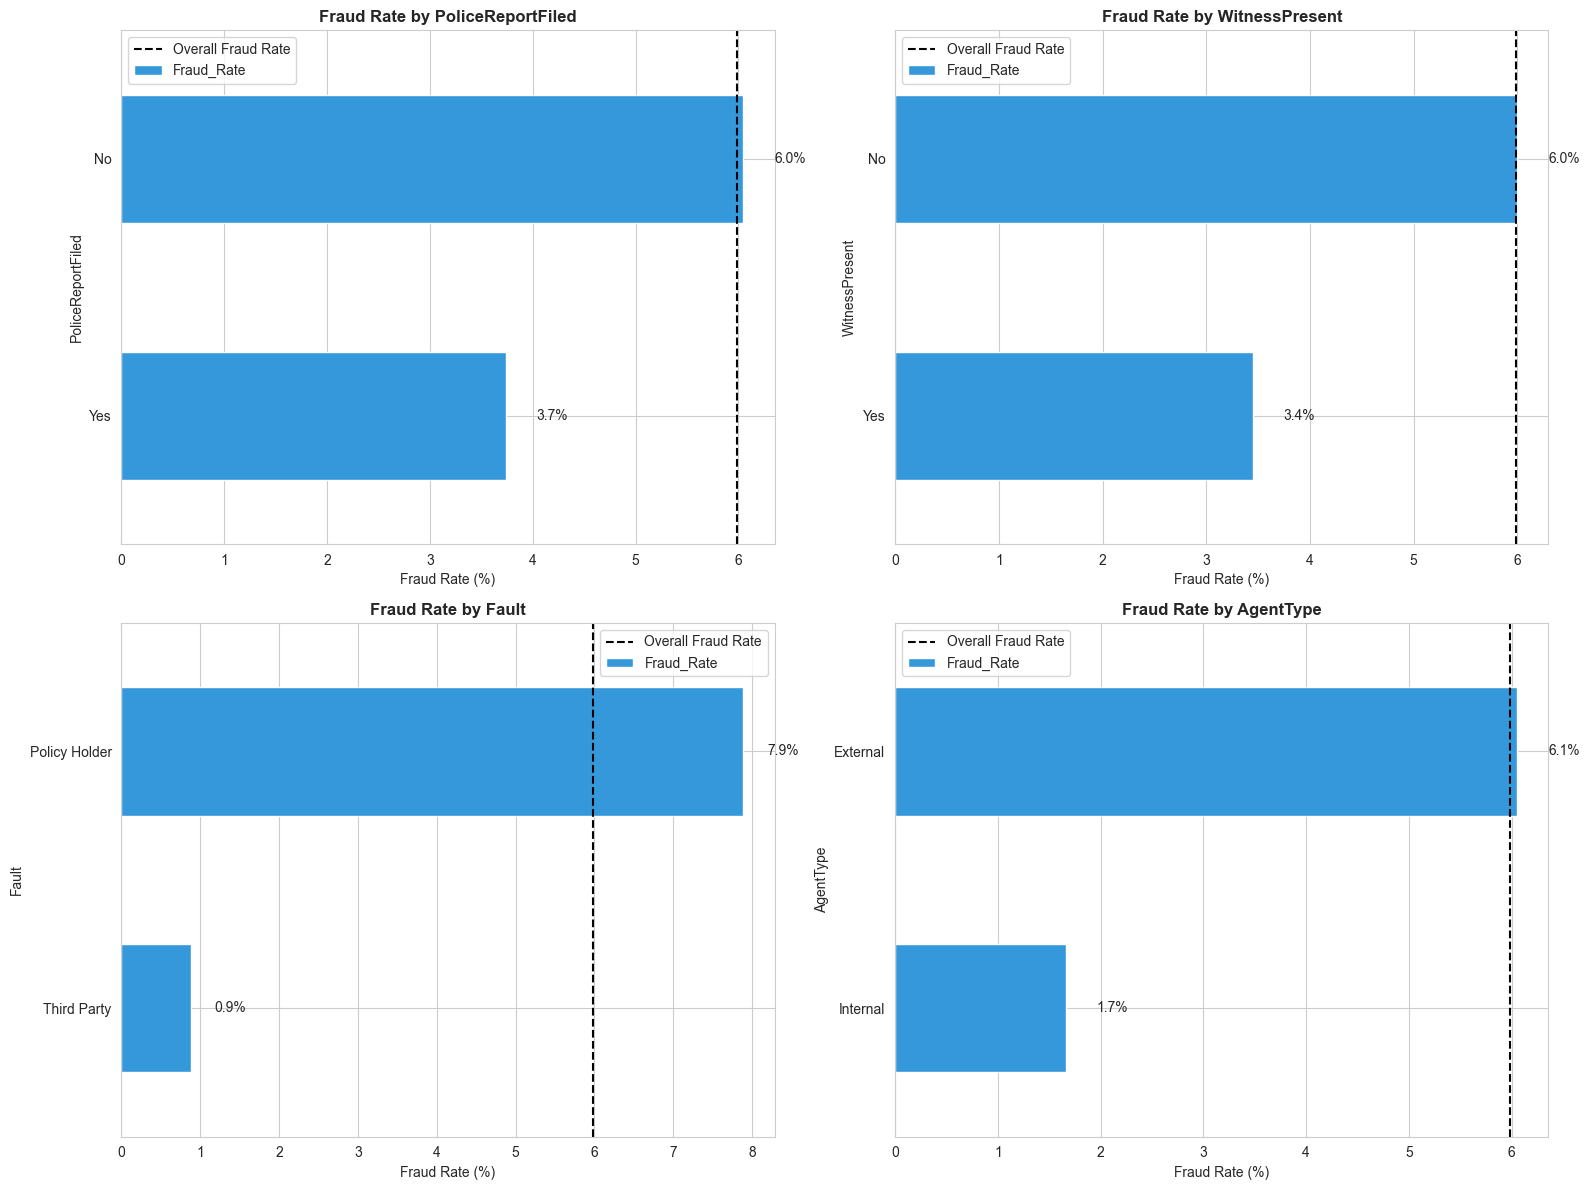

In [9]:
# 9: Visualize fraud rates for key features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

features_to_plot = ['PoliceReportFiled', 'WitnessPresent', 'Fault', 'AgentType']

for idx, col in enumerate(features_to_plot):
    data = fraud_rates[col]['Fraud_Rate'].sort_values(ascending=True)
    
    colors = ['#e74c3c' if x > 10 else '#3498db' for x in data.values]
    
    data.plot(kind='barh', ax=axes[idx], color=colors)
    axes[idx].set_title(f'Fraud Rate by {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Fraud Rate (%)')
    axes[idx].axvline(x=df['FraudFound_P'].mean()*100, color='black', 
                      linestyle='--', label='Overall Fraud Rate')
    axes[idx].legend()
    
    # Add percentage labels
    for i, v in enumerate(data.values):
        axes[idx].text(v + 0.3, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.savefig('../data/processed/fraud_rates_categorical.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# 10: Cross-tabulation analysis
print("=== CROSS-TABULATION: Key Feature Combinations ===\n")

# Example: PoliceReportFiled vs WitnessPresent
crosstab = pd.crosstab(
    [df['PoliceReportFiled'], df['WitnessPresent']], 
    df['FraudFound_P'], 
    normalize='index'
) * 100

print("Fraud Rate (%) by PoliceReport & Witness:")
print(crosstab[1].sort_values(ascending=False))
print("\n" + "="*60)

# Example: Fault vs AgentType
crosstab2 = pd.crosstab(
    [df['Fault'], df['AgentType']], 
    df['FraudFound_P'], 
    normalize='index'
) * 100

print("\nFraud Rate (%) by Fault & AgentType:")
print(crosstab2[1].sort_values(ascending=False))

=== CROSS-TABULATION: Key Feature Combinations ===

Fraud Rate (%) by PoliceReport & Witness:
PoliceReportFiled  WitnessPresent
No                 No                6.055537
                   Yes               4.255319
Yes                No                3.865979
                   Yes               2.500000
Name: 1, dtype: float64


Fraud Rate (%) by Fault & AgentType:
Fault          AgentType
Policy Holder  External     7.975405
               Internal     2.339181
Third Party    External     0.898058
               Internal     0.000000
Name: 1, dtype: float64


In [11]:
# 11: Prepare numerical data for correlation
# Convert some ordinal categoricals to numeric for correlation
df_numeric = df.copy()

# Map ordinals
ordinal_mappings = {
    'AgeOfVehicle': {'new': 0, '2 years': 2, '3 years': 3, '4 years': 4, 
                     '5 years': 5, '6 years': 6, '7 years': 7, 'more than 7': 8},
    'VehiclePrice': {'less than 20000': 1, '20000 to 29000': 2, '30000 to 39000': 3,
                     '40000 to 59000': 4, '60000 to 69000': 5, 'more than 69000': 6}
}

for col, mapping in ordinal_mappings.items():
    if col in df_numeric.columns:
        df_numeric[col + '_numeric'] = df_numeric[col].map(mapping)

# Select numeric columns for correlation
corr_cols = numerical_cols + [col + '_numeric' for col in ordinal_mappings.keys() 
                               if col + '_numeric' in df_numeric.columns]
corr_cols.append('FraudFound_P')

correlation_matrix = df_numeric[corr_cols].corr()

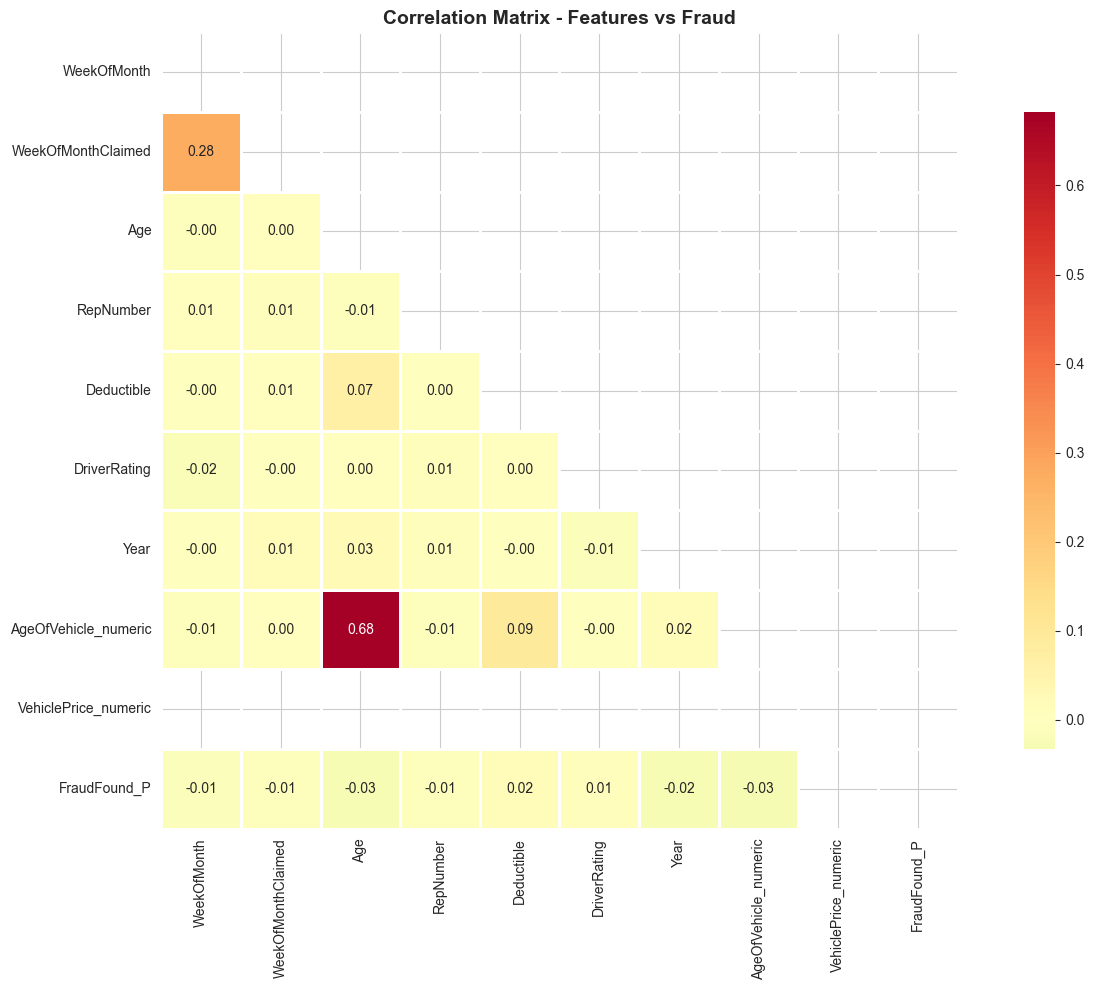

In [12]:
# 12: Correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdYlGn_r', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Features vs Fraud', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../data/processed/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()